In [18]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("muted")
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
%%bigquery batch_pred
SELECT
    *
FROM 
`prediction_demo3_v2_2019_07_29T23_43_46_125Z.predictions`

In [5]:
batch_pred.head()

,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,start_month,start_hour,dayOfWeek,trip_seconds,dayOfYear,price_per_mile,predicted_price_per_mile
0,0.90,41.857184,-87.620335,41.857184,-87.620335,2.0,11.0,4,180.0,38.0,6.111111,[{'tables': {'prediction_interval': {'start': ...
1,1.90,41.857184,-87.620335,41.878866,-87.625192,6.0,3.0,3,600.0,156.0,4.736842,[{'tables': {'prediction_interval': {'start': ...
2,2.40,41.849247,-87.624135,41.877406,-87.621972,4.0,12.0,4,1111.0,94.0,4.791667,[{'tables': {'prediction_interval': {'start': ...
3,2.42,41.849247,-87.624135,41.877406,-87.621972,5.0,11.0,4,737.0,150.0,4.132231,[{'tables': {'prediction_interval': {'start': ...
4,2.20,41.849247,-87.624135,41.877406,-87.621972,6.0,11.0,2,840.0,169.0,4.545455,[{'tables': {'prediction_interval': {'start': ...


In [10]:
# apply function to get prediction results from AutoML Tables, then update pd dataframe

def prediction(x):
    """
    decode the prediction from the nested table in Bigquery
    """
    return x[0]['tables']['value']

prediction = batch_pred['predicted_price_per_mile'].apply(prediction)

batch_pred['prediction'] = prediction

batch_pred.head()

,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,start_month,start_hour,dayOfWeek,trip_seconds,dayOfYear,price_per_mile,predicted_price_per_mile,prediction
0,0.90,41.857184,-87.620335,41.857184,-87.620335,2.0,11.0,4,180.0,38.0,6.111111,[{'tables': {'prediction_interval': {'start': ...,5.963612
1,1.90,41.857184,-87.620335,41.878866,-87.625192,6.0,3.0,3,600.0,156.0,4.736842,[{'tables': {'prediction_interval': {'start': ...,4.623542
2,2.40,41.849247,-87.624135,41.877406,-87.621972,4.0,12.0,4,1111.0,94.0,4.791667,[{'tables': {'prediction_interval': {'start': ...,4.897396
3,2.42,41.849247,-87.624135,41.877406,-87.621972,5.0,11.0,4,737.0,150.0,4.132231,[{'tables': {'prediction_interval': {'start': ...,4.202617
4,2.20,41.849247,-87.624135,41.877406,-87.621972,6.0,11.0,2,840.0,169.0,4.545455,[{'tables': {'prediction_interval': {'start': ...,4.664961


In [11]:
batch_pred['prediction'].describe()

count    2421.000000
mean        6.507680
std         2.110993
min         2.732201
25%         5.068596
50%         6.119946
75%         7.453267
max        22.148682
Name: prediction, dtype: float64

In [12]:
batch_pred = batch_pred.dropna(axis='rows')
print(batch_pred.shape) 
batch_pred.head()

(2421, 13)


,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,start_month,start_hour,dayOfWeek,trip_seconds,dayOfYear,price_per_mile,predicted_price_per_mile,prediction
0,0.90,41.857184,-87.620335,41.857184,-87.620335,2.0,11.0,4,180.0,38.0,6.111111,[{'tables': {'prediction_interval': {'start': ...,5.963612
1,1.90,41.857184,-87.620335,41.878866,-87.625192,6.0,3.0,3,600.0,156.0,4.736842,[{'tables': {'prediction_interval': {'start': ...,4.623542
2,2.40,41.849247,-87.624135,41.877406,-87.621972,4.0,12.0,4,1111.0,94.0,4.791667,[{'tables': {'prediction_interval': {'start': ...,4.897396
3,2.42,41.849247,-87.624135,41.877406,-87.621972,5.0,11.0,4,737.0,150.0,4.132231,[{'tables': {'prediction_interval': {'start': ...,4.202617
4,2.20,41.849247,-87.624135,41.877406,-87.621972,6.0,11.0,2,840.0,169.0,4.545455,[{'tables': {'prediction_interval': {'start': ...,4.664961


In [14]:
batch_pred['AE'] = batch_pred.apply(lambda x: np.abs(x['price_per_mile'] - x['prediction']), axis=1)
batch_pred['SE'] = batch_pred.apply(lambda x: np.abs(x['price_per_mile'] - x['prediction'])**2, axis=1)

In [15]:
batch_pred['AE'].describe()

count    2421.000000
mean        0.172470
std         0.213489
min         0.000035
25%         0.054661
50%         0.119179
75%         0.220290
max         4.396381
Name: AE, dtype: float64

In [16]:
batch_pred['SE'].describe()

count    2.421000e+03
mean     7.530437e-02
std      5.174020e-01
min      1.233696e-09
25%      2.987866e-03
50%      1.420373e-02
75%      4.852756e-02
max      1.932816e+01
Name: SE, dtype: float64

In [19]:
MAE1 = mean_absolute_error(batch_pred['price_per_mile'], batch_pred['prediction'])
print('MAE is: ', MAE1)

MAE is:  0.17246985700697917


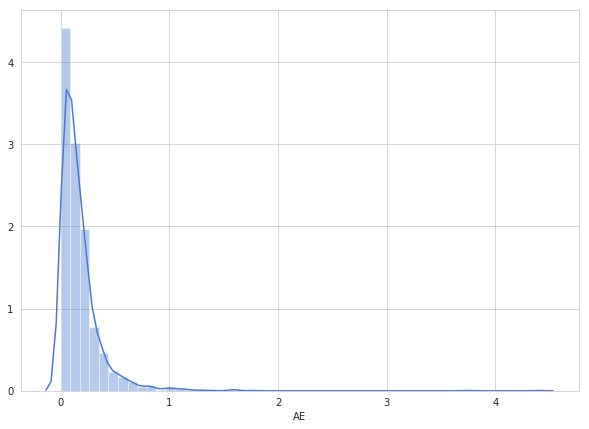

In [20]:
plt.figure(figsize=(10,7))
sns.distplot(batch_pred['AE'])

In [21]:
batch_pred['SE'].describe()

count    2.421000e+03
mean     7.530437e-02
std      5.174020e-01
min      1.233696e-09
25%      2.987866e-03
50%      1.420373e-02
75%      4.852756e-02
max      1.932816e+01
Name: SE, dtype: float64

In [22]:
RMSE1 = mean_squared_error(batch_pred['price_per_mile'], batch_pred['prediction'])
print('RMSE is: ', RMSE1)

RMSE is:  0.0753043710759436


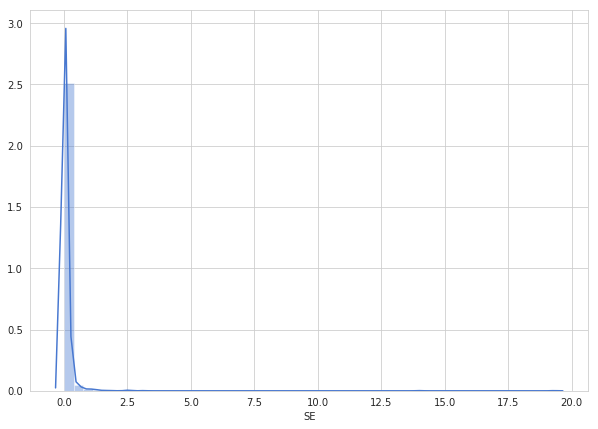

In [23]:
plt.figure(figsize=(10,7))
sns.distplot(batch_pred['SE'])

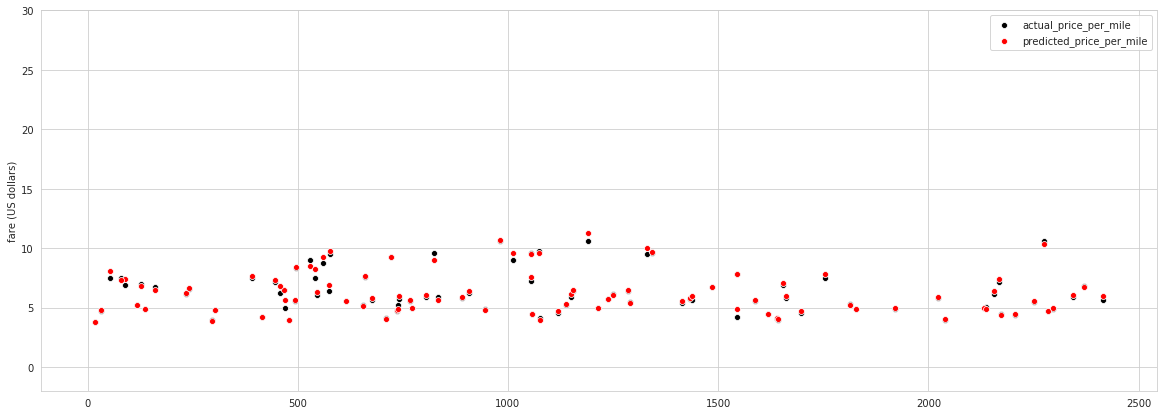

In [41]:
# randomly pick 100 predict sample to visualize the difference between actual value and predicted value

import random
index = []
for i in range(100):
          r=random.randint(1,len(batch_pred))
          if r not in index: index.append(r)

plt.figure(figsize=(20,7))
plt.gca().set_ylim(top=30)
plt.gca().set_ylim(bottom=-2)
sns.scatterplot(index, batch_pred.ix[index, 'price_per_mile'], color='black')
sns.scatterplot(index, batch_pred.ix[index, 'prediction'], color='red')
plt.gca().legend(('actual_price_per_mile','predicted_price_per_mile'))
plt.ylabel('fare (US dollars)')
plt.show()